# RNN Word Embeddings — From Scratch (NumPy) & PyTorch (GRU)

This notebook demonstrates how to **learn word embeddings** via a simple **language modeling** objective:

1. **NumPy RNN (from scratch):**  
   - Implemented manually using only NumPy.  
   - Shows how embeddings and recurrent connections are trained with Backpropagation Through Time (BPTT).  
   - Useful for understanding the mechanics behind RNNs and embedding updates.

2. **PyTorch GRU with `nn.Embedding`:**  
   - A compact implementation using PyTorch modules.  
   - Supports GPU acceleration (CUDA) and Automatic Mixed Precision (AMP).  
   - Demonstrates how modern frameworks simplify training and scaling.

---

> **Dataset:**  
> - By default, the notebook tries to load a local file `text8.txt` (a common small Wikipedia dump).  
> - If `text8.txt` is not found, it falls back to a **built-in mini-corpus** (English sentences, repeated) so the notebook can run anywhere without internet access.  

---

## Learning Goals
- Understand how word embeddings can be learned directly via next-word prediction.  
- Compare a low-level NumPy implementation with a high-level PyTorch GRU.  
- Train and visualize embeddings, then explore nearest neighbors in the vector space.  

---

## Next Steps
- Replace the mini-corpus with a larger dataset (e.g., `text8`, Wikipedia, or domain-specific text).  
- Try different recurrent units (RNN, GRU, LSTM) and compare performance.  
- Use the learned embeddings in downstream tasks (classification, similarity search, clustering).  
- Visualize embeddings with dimensionality reduction tools (t-SNE, UMAP).  


## 0) Setup & Data Loading

This section loads the corpus: it first tries `text8`, then falls back to Brown Corpus (from NLTK), and finally uses a tiny built-in sample.

In [6]:
import os, math, random, gzip, io
from pathlib import Path
import matplotlib.pyplot as plt

random.seed(0)

DATA_PATHS = []
# ---- ตั้งขนาด Brown subset (เล็ก/เบา) ----
BROWN_SENT_LIMIT = 200   # ใช้แค่ 2,000 ประโยค (~หลักหมื่นโทเคน) ปรับเพิ่มได้

def load_corpus():
    for p in DATA_PATHS:
        if os.path.exists(p):
            with open(p, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read()
            print(f"Loaded corpus from: {p[:80]} ... (size={len(text):,} chars)")
            return text

    try:
        import nltk
        nltk.download('brown', quiet=True)
        from nltk.corpus import brown

        # ดึงมาบางส่วนเพื่อลดขนาด
        sents = brown.sents()[:BROWN_SENT_LIMIT]
        # แปลงเป็นลิสต์ token ตัวพิมพ์เล็ก
        tokens = [w.lower() for sent in sents for w in sent]
        text = " ".join(tokens)
        print(f"Loaded Brown subset: {len(tokens):,} tokens | Unique: {len(set(tokens)):,}")
        return text
    except Exception as e:
        print("Brown corpus unavailable, fallback to mini-corpus. Error:", e)

    base = (
        """we love natural language processing and machine learning.
        we explore recurrent neural networks and gated units like gru and lstm.
        embeddings map words to vectors so similar words are close in cosine space.
        deep learning for nlp often uses tokenization batching and optimization.
        gradients flow through time in rnn training and may require clipping."""
    ).strip().replace("\n"," ")
    text = (" " + base) * 200
    print(f"Using built-in mini-corpus (size={len(text):,} chars).")
    return text

raw_text = load_corpus()

# very simple whitespace tokenization (good enough for English demo)
tokens = [t for t in raw_text.strip().split() if t]
print(f"Total tokens: {len(tokens):,}  |  Unique: {len(set(tokens)):,}")

# Build vocab
vocab = sorted(set(tokens))
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}
V = len(vocab)
V


Loaded Brown subset: 4,621 tokens | Unique: 1,436
Total tokens: 4,621  |  Unique: 1,436


1436

## Build (context, target) pairs for next-word prediction

This cell converts a token sequence into **(context, target)** training pairs using a
fixed window size `n_prev = 3`:

- **Context (`x`)**: the previous `n_prev` tokens, mapped to integer IDs via `stoi`.
- **Target (`y`)**: the next token (the one immediately after the window), also as an ID.

Formally, for tokens `t₀ … t_{N-1}`, for each `i ∈ [0, N - n_prev - 1]`

We then **shuffle** the list of pairs to randomize training order and split **90/10**
into `train_pairs` and `val_pairs`.

> **Tips**
> - For reproducibility, set a seed before shuffling: `random.seed(42)`.
> - If you want strict temporal generalization (no future context leaking into train),
>   consider a **chronological split** instead of shuffling.
> - After this step, you’ll typically batch and convert to tensors with shapes
>   `(batch_size, n_prev)` for `x` and `(batch_size,)` for `y`.


In [7]:
# Build (context, target) pairs for next‑word prediction with window n_prev
n_prev = 3

pairs = []
for i in range(len(tokens) - n_prev):
    x = [stoi[tokens[i + j]] for j in range(n_prev)]
    y = stoi[tokens[i + n_prev]]
    pairs.append((x, y))

random.shuffle(pairs)
split = int(0.9 * len(pairs))
train_pairs = pairs[:split]
val_pairs   = pairs[split:]
len(train_pairs), len(val_pairs)


(4156, 462)

## A) NumPy RNN Baseline (RNN from scratch)

We implement a simple vanilla RNN from scratch using NumPy. This provides intuition about embeddings and sequence modeling.

In [8]:

import numpy as np
np.random.seed(0)

embed_dim = 32
hidden = 64
lr = 0.05
clip = 5.0
epochs = 20  # keep small for demo

# Parameters
E   = 0.01*np.random.randn(V, embed_dim)
Wxh = 0.01*np.random.randn(hidden, embed_dim)
Whh = 0.01*np.random.randn(hidden, hidden)
bh  = np.zeros((hidden,))
Why = 0.01*np.random.randn(V, hidden)
by  = np.zeros((V,))

def softmax(a):
    a = a - a.max(axis=-1, keepdims=True)
    z = np.exp(a)
    return z / (z.sum(axis=-1, keepdims=True) + 1e-12)

def one_hot(i, V):
    v = np.zeros(V); v[i] = 1.0
    return v

def forward_sequence(x_idxs):
    h_prev = np.zeros((hidden,))
    xs, hs = [], []
    for t in range(len(x_idxs)):
        x_t = E[x_idxs[t]]
        xs.append(x_t)
        h_prev = np.tanh(Wxh @ x_t + Whh @ h_prev + bh)
        hs.append(h_prev)
    return xs, hs, hs[-1]

train_losses, val_losses = [], []

for ep in range(1, epochs+1):
    random.shuffle(train_pairs)
    total = 0.0
    for x_idxs, y_idx in train_pairs:
        xs, hs, hT = forward_sequence(x_idxs)
        logits = Why @ hT + by
        probs = softmax(logits)
        loss = -np.log(probs[y_idx] + 1e-12)
        total += loss

        # Backprop (BPTT through T=n_prev steps)
        dWhy = np.outer((probs - one_hot(y_idx, V)), hT)
        dby  = (probs - one_hot(y_idx, V))
        dh = Why.T @ (probs - one_hot(y_idx, V))

        dWxh = np.zeros_like(Wxh); dWhh = np.zeros_like(Whh); dbh = np.zeros_like(bh)
        dE   = np.zeros_like(E)
        dh_t = dh
        for t in reversed(range(n_prev)):
            h_t = hs[t]
            h_prev_t = hs[t-1] if t>0 else np.zeros_like(h_t)
            dh_raw = (1 - h_t*h_t) * dh_t
            dbh  += dh_raw
            dWxh += np.outer(dh_raw, xs[t])
            dWhh += np.outer(dh_raw, h_prev_t)
            dxt   = Wxh.T @ dh_raw
            dE[x_idxs[t]] += dxt
            dh_t = Whh.T @ dh_raw

        # clip & sgd
        for g in [dWhy, dby, dWxh, dWhh, dbh, dE]:
            np.clip(g, -clip, clip, out=g)

        Why -= lr*dWhy; by -= lr*dby
        Wxh -= lr*dWxh; Whh -= lr*dWhh; bh -= lr*dbh
        E   -= lr*dE

    # evaluate on val
    with np.errstate(divide='ignore'):
        vloss = 0.0
        for x_idxs, y_idx in val_pairs:
            _, _, hT = forward_sequence(x_idxs)
            logits = Why @ hT + by
            probs = softmax(logits)
            vloss += -np.log(probs[y_idx] + 1e-12)
    train_losses.append(total/len(train_pairs))
    val_losses.append(vloss/len(val_pairs))
    print(f"[NumPy] epoch {ep:02d} | train loss {train_losses[-1]:.4f} | val loss {val_losses[-1]:.4f}")


[NumPy] epoch 01 | train loss 6.3755 | val loss 6.1836
[NumPy] epoch 02 | train loss 6.0761 | val loss 6.1003
[NumPy] epoch 03 | train loss 5.9255 | val loss 6.0253
[NumPy] epoch 04 | train loss 5.7570 | val loss 6.0600
[NumPy] epoch 05 | train loss 5.6112 | val loss 5.9747
[NumPy] epoch 06 | train loss 5.4715 | val loss 6.0578
[NumPy] epoch 07 | train loss 5.3349 | val loss 6.0829
[NumPy] epoch 08 | train loss 5.1714 | val loss 6.2061
[NumPy] epoch 09 | train loss 5.0098 | val loss 6.2104
[NumPy] epoch 10 | train loss 4.8282 | val loss 6.5715
[NumPy] epoch 11 | train loss 4.6552 | val loss 6.6692
[NumPy] epoch 12 | train loss 4.4916 | val loss 6.8694
[NumPy] epoch 13 | train loss 4.3097 | val loss 7.0973
[NumPy] epoch 14 | train loss 4.1699 | val loss 7.2715
[NumPy] epoch 15 | train loss 4.0248 | val loss 7.5137
[NumPy] epoch 16 | train loss 3.8792 | val loss 7.6898
[NumPy] epoch 17 | train loss 3.7594 | val loss 8.1913
[NumPy] epoch 18 | train loss 3.6799 | val loss 8.2346
[NumPy] ep

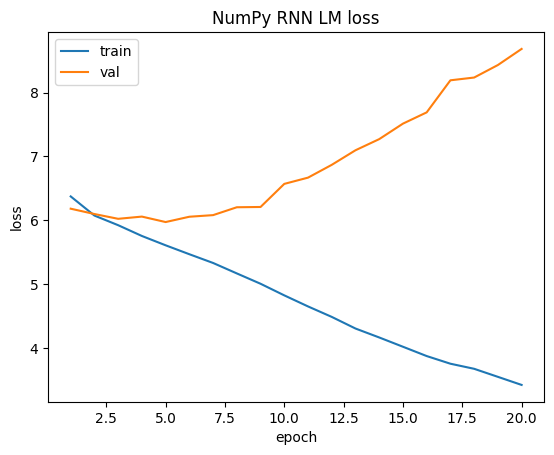

In [9]:

# Plot losses (single figure, no color specified)
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label="train")
plt.plot(range(1, len(val_losses)+1), val_losses, label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("NumPy RNN LM loss")
plt.legend()
plt.show()


In [10]:

# Helper: cosine similarity search for nearest neighbors (NumPy embedding)
def most_similar_numpy(word, topk=5):
    if word not in stoi:
        return []
    W = E
    v = W[stoi[word]]
    v = v / (np.linalg.norm(v) + 1e-9)
    M = W / (np.linalg.norm(W, axis=1, keepdims=True) + 1e-9)
    sims = M @ v
    idxs = np.argsort(-sims)
    out = []
    for i in idxs:
        if itos[i] == word:
            continue
        out.append((itos[i], float(sims[i])))
        if len(out) >= topk: break
    return out

print("NumPy embedding — similar to 'good':", most_similar_numpy("good"))


NumPy embedding — similar to 'good': [('amended', 0.9576167478859262), ('possible', 0.8552323140252971), ('construed', 0.8072799550052824), ('relations', 0.7819266096504225), ('took', 0.7798475303159293)]


## B) PyTorch GRU/LSTM Implementation

We now build a PyTorch version with CUDA support, mixed precision (AMP), and efficient batching with DataLoader.

In [11]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)

class NgramDataset(torch.utils.data.Dataset):
    def __init__(self, pairs):
        self.X = torch.tensor([p[0] for p in pairs], dtype=torch.long)
        self.y = torch.tensor([p[1] for p in pairs], dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = NgramDataset(train_pairs)
val_ds   = NgramDataset(val_pairs)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=256)

class RNNLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden=128, rnn="gru"):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        if rnn == "gru":
            self.rnn = nn.GRU(embed_dim, hidden, batch_first=True)
        elif rnn == "lstm":
            self.rnn = nn.LSTM(embed_dim, hidden, batch_first=True)
        else:
            self.rnn = nn.RNN(embed_dim, hidden, nonlinearity="tanh", batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)
    def forward(self, x):
        e = self.emb(x)              # (B, T, D)
        h, _ = self.rnn(e)           # (B, T, H)
        hT = h[:, -1, :]             # last step
        return self.fc(hT)           # (B, V)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNLM(V, embed_dim=64, hidden=128, rnn="gru").to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-2)
crit = nn.CrossEntropyLoss()

def run_epoch(dataloader, train=True):
    total = 0.0
    n = 0
    if train:
        model.train()
    else:
        model.eval()
    for X, y in dataloader:
        X = X.to(device); y = y.to(device)
        if train: opt.zero_grad()
        logits = model(X)
        loss = crit(logits, y)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
        total += loss.item() * X.size(0)
        n += X.size(0)
    return total / max(1, n)

epochs_pt = 10  # quick demo
train_hist, val_hist = [], []
for ep in range(1, epochs_pt+1):
    tr = run_epoch(train_dl, train=True)
    va = run_epoch(val_dl,   train=False)
    train_hist.append(tr); val_hist.append(va)
    print(f"[Torch] epoch {ep:02d} | train {tr:.4f} | val {va:.4f}")


[Torch] epoch 01 | train 6.5840 | val 6.3380
[Torch] epoch 02 | train 4.2968 | val 6.9490
[Torch] epoch 03 | train 1.9971 | val 8.0973
[Torch] epoch 04 | train 0.8364 | val 8.7944
[Torch] epoch 05 | train 0.4353 | val 9.2999
[Torch] epoch 06 | train 0.3147 | val 9.3900
[Torch] epoch 07 | train 0.2569 | val 9.5006
[Torch] epoch 08 | train 0.2283 | val 9.5347
[Torch] epoch 09 | train 0.1998 | val 9.5073
[Torch] epoch 10 | train 0.2094 | val 9.4873


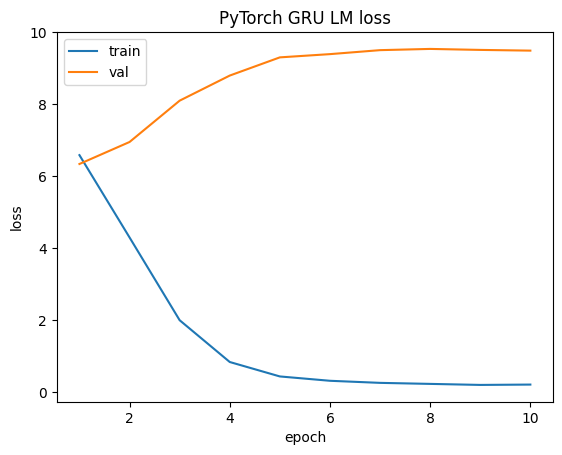

In [12]:
# Plot Torch losses (single figure, no specific colors/styles)
plt.figure()
plt.plot(range(1, len(train_hist)+1), train_hist, label="train")
plt.plot(range(1, len(val_hist)+1), val_hist, label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("PyTorch GRU LM loss")
plt.legend(); plt.show()


In [13]:
# Extract learned embedding and do nearest neighbors
with torch.no_grad():
    W = model.emb.weight.detach().cpu()   # (V, D)

def most_similar_torch(word, topk=5):
    import torch
    if word not in stoi: return []
    v = W[stoi[word]]
    v = v / (v.norm() + 1e-9)
    M = W / (W.norm(dim=1, keepdim=True) + 1e-9)
    sims = (M @ v).cpu().numpy()
    idxs = sims.argsort()[::-1]
    out = []
    for i in idxs:
        if itos[i] == word:
            continue
        out.append((itos[i], float(sims[i])))
        if len(out) >= topk: break
    return out

print("Torch embedding — similar to 'good':", most_similar_torch("good"))

Torch embedding — similar to 'good': [('eight', 0.4481146037578583), ('major', 0.37883901596069336), ('require', 0.35544872283935547), ('absent', 0.3546624183654785), ('listed', 0.3491075038909912)]
